In [ ]:
#纯fixmatch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.models as models
import pandas as pd
import numpy as np
from PIL import Image
import io
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random
import os
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')#

Mounted at /content/drive


In [ ]:
# 设置随机种子，确保实验可复现
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

def extract_modality(text):
    """从文本中提取modality信息"""
    if not isinstance(text, str):
        return None

    text = text.lower()
    modality_patterns = {
        'mri': r'\b(mri|magnetic resonance( imaging)?|mr imaging|nmr|magnetic resonance imaging)\b',
        'ct': r'\b(ct scan|ct|computed tomography|cat scan|computerized tomography|computed axial tomography)\b',
        'xray': r'\b(x-ray|xray|radiograph|radiography|chest x|cxr|roentgen|radiogram|plain film)\b'
    }

    for modality, pattern in modality_patterns.items():
        if re.search(pattern, text):
            return modality
    return None

In [ ]:
# 基础模型 - 纯FixMatch版本
class BaseModalityClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.modality_head = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.modality_head(features)

# 医学注意力模块
class MedicalModalityAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.anatomy_attention = nn.Sequential(
            nn.Conv2d(in_channels, in_channels//2, kernel_size=7, padding=3),
            nn.BatchNorm2d(in_channels//2),
            nn.ReLU(),
            nn.Conv2d(in_channels//2, 1, kernel_size=1),
            nn.Sigmoid()
        )

        self.texture_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels//16, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels//16, in_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        anatomy_weight = self.anatomy_attention(x)
        texture_weight = self.texture_attention(x)
        return x * anatomy_weight * texture_weight

# 注意力模型 - FixMatch+医学注意力版本
class AttentionModalityClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        self.attention1 = MedicalModalityAttention(256)
        self.attention2 = MedicalModalityAttention(512)
        self.attention3 = MedicalModalityAttention(1024)
        self.attention4 = MedicalModalityAttention(2048)

        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.modality_head = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.attention1(self.backbone.layer1(x))
        x = self.attention2(self.backbone.layer2(x))
        x = self.attention3(self.backbone.layer3(x))
        x = self.attention4(self.backbone.layer4(x))

        x = self.backbone.avgpool(x)
        features = torch.flatten(x, 1)
        return self.modality_head(features)

# 保持原有的数据增强策略
class MedicalImageAugmentation:
    def __init__(self):
        self.base_aug = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.RandomAffine(
                degrees=0,
                translate=(0.1, 0.1),
                scale=(0.9, 1.1)
            ),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

        self.strong_aug = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.RandomAffine(
                degrees=0,
                translate=(0.15, 0.15),
                scale=(0.85, 1.15)
            ),
            transforms.ColorJitter(
                brightness=0.3,
                contrast=0.3,
                saturation=0.2,
                hue=0.1
            ),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

        self.test_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

# 数据集类保持不变
class RADDataset(Dataset):
    def __init__(self, df, is_labeled=True, mode='train'):
        self.df = df
        self.is_labeled = is_labeled
        self.mode = mode
        self.augmentation = MedicalImageAugmentation()

        self.valid_samples = []
        self.unlabeled_samples = []
        self.modality_to_idx = {'mri': 0, 'ct': 1, 'xray': 2}

        for idx, row in df.iterrows():
            question_modality = extract_modality(row['question'])
            answer_modality = extract_modality(row['answer'])
            modality = question_modality or answer_modality

            if modality in ['mri', 'ct', 'xray']:
                self.valid_samples.append({
                    'image': row['image'],
                    'modality': modality,
                    'index': idx
                })
            else:
                self.unlabeled_samples.append({
                    'image': row['image'],
                    'index': idx
                })

    def decode_image(self, image_data):
        try:
            if isinstance(image_data, dict):
                if 'bytes' in image_data:
                    bytes_data = image_data['bytes']
                    if isinstance(bytes_data, str):
                        bytes_data = bytes_data.encode('latin1')
                    img = Image.open(io.BytesIO(bytes_data))
                    return np.array(img)
                elif 'array' in image_data:
                    return np.array(image_data['array'])
            return np.array(image_data)
        except Exception as e:
            print(f"Error decoding image: {str(e)}")
            raise

    def __len__(self):
        if self.is_labeled:
            return len(self.valid_samples)
        return len(self.unlabeled_samples)

    def __getitem__(self, idx):
        if self.is_labeled:
            sample = self.valid_samples[idx]
            image_data = sample['image']
            label = self.modality_to_idx[sample['modality']]

            if self.mode == 'train':
                image_tensor = self._process_image(image_data, aug_type='base')
            else:
                image_tensor = self._process_image(image_data, aug_type='test')
            return image_tensor, label
        else:
            sample = self.unlabeled_samples[idx]
            image_data = sample['image']
            weak_aug = self._process_image(image_data, aug_type='base')
            strong_aug = self._process_image(image_data, aug_type='strong')
            return weak_aug, strong_aug

    def _process_image(self, image_data, aug_type='base'):
        try:
            image_array = self.decode_image(image_data)
            if len(image_array.shape) == 2:
                image_array = np.stack([image_array] * 3, axis=-1)
            elif len(image_array.shape) == 3 and image_array.shape[2] == 4:
                image_array = image_array[:, :, :3]

            image = Image.fromarray(image_array.astype('uint8'))

            if aug_type == 'strong':
                return self.augmentation.strong_aug(image)
            elif aug_type == 'test':
                return self.augmentation.test_transform(image)
            else:
                return self.augmentation.base_aug(image)
        except Exception as e:
            print(f"Error processing image: {str(e)}")
            raise


In [ ]:
def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    modality_correct = {'mri': 0, 'ct': 0, 'xray': 0}
    modality_total = {'mri': 0, 'ct': 0, 'xray': 0}

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # 计算每个模态的准确率
            for i, (pred, label) in enumerate(zip(predicted, labels)):
                modality = ['mri', 'ct', 'xray'][label.item()]
                modality_total[modality] += 1
                if pred == label:
                    modality_correct[modality] += 1

    avg_loss = total_loss / len(val_loader)
    overall_acc = correct / total

    modality_accuracies = {
        modality: modality_correct[modality]/modality_total[modality]
        for modality in ['mri', 'ct', 'xray']
        if modality_total[modality] > 0
    }

    return avg_loss, overall_acc, modality_accuracies

In [ ]:
# FixMatch训练函数
def train_fixmatch(model, train_loader, unlabeled_loader, val_loader, device, model_name):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

    # 创建保存目录
    save_dir = '/content/drive/MyDrive/PhD/Research1/output'
    os.makedirs(save_dir, exist_ok=True)

    num_epochs = 10
    threshold = 0.95  # 伪标签置信度阈值
    best_acc = 0
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'modality_metrics': []
    }

    print(f"\nTraining {model_name}...")
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        modality_correct = {'mri': 0, 'ct': 0, 'xray': 0}
        modality_total = {'mri': 0, 'ct': 0, 'xray': 0}

        unlabeled_iter = iter(unlabeled_loader)
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

        for batch_idx, (inputs, labels) in enumerate(pbar):
            inputs = inputs.to(device)
            labels = labels.to(device)

            try:
                weak_aug, strong_aug = next(unlabeled_iter)
            except StopIteration:
                unlabeled_iter = iter(unlabeled_loader)
                weak_aug, strong_aug = next(unlabeled_iter)

            weak_aug = weak_aug.to(device)
            strong_aug = strong_aug.to(device)

            optimizer.zero_grad()

            # 有标签数据的监督损失
            outputs = model(inputs)
            sup_loss = criterion(outputs, labels)

            # 无标签数据的伪标签
            with torch.no_grad():
                pseudo_outputs = model(weak_aug)
                pseudo_probs = F.softmax(pseudo_outputs, dim=1)
                max_probs, pseudo_labels = torch.max(pseudo_probs, dim=1)
                mask = max_probs.ge(threshold)

            # 无标签数据的一致性正则化
            strong_outputs = model(strong_aug)
            unsup_loss = (F.cross_entropy(strong_outputs, pseudo_labels,
                                        reduction='none') * mask).mean()

            loss = sup_loss + unsup_loss
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # 计算每个模态的准确率
            for i, (pred, label) in enumerate(zip(predicted, labels)):
                modality = ['mri', 'ct', 'xray'][label.item()]
                modality_total[modality] += 1
                if pred == label:
                    modality_correct[modality] += 1

            total_loss += loss.item()

            pbar.set_postfix({
                'Loss': f'{total_loss/(batch_idx+1):.3f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })

        # 计算训练集上每个模态的准确率
        train_acc = correct / total
        modality_accuracies = {
            modality: modality_correct[modality]/modality_total[modality]
            for modality in ['mri', 'ct', 'xray']
            if modality_total[modality] > 0
        }

        # 验证
        val_loss, val_acc, val_modality_acc = evaluate(model, val_loader, criterion, device)
        scheduler.step()

        # 打印当前epoch的结果
        print(f'\nEpoch {epoch+1}:')
        print(f'Training Loss: {total_loss/(batch_idx+1):.4f}')
        print(f'Training Accuracy: {100.*train_acc:.2f}%')
        print('Training Modality Accuracies:')
        for modality, acc in modality_accuracies.items():
            print(f'{modality.upper()}: {100.*acc:.2f}%')

        print(f'\nValidation Loss: {val_loss:.4f}')
        print(f'Validation Accuracy: {100.*val_acc:.2f}%')
        print('Validation Modality Accuracies:')
        for modality, acc in val_modality_acc.items():
            print(f'{modality.upper()}: {100.*acc:.2f}%')

        # 更新历史记录
        history['train_loss'].append(total_loss/(batch_idx+1))
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['modality_metrics'].append(val_modality_acc)

        # 保存最佳模型 - 使用绝对路径
        if val_acc > best_acc:
            best_acc = val_acc
            save_path = os.path.join(save_dir, f'{model_name}_best.pth')
            print(f'\nSaving new best model with validation accuracy: {100.*best_acc:.2f}% to {save_path}')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_acc': best_acc,
                'history': history
            }, save_path)

    return history

def plot_training_history(base_history, attention_history):
    # 绘制总体准确率对比
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(base_history['train_acc'], label='Base Train')
    plt.plot(base_history['val_acc'], label='Base Val')
    plt.plot(attention_history['train_acc'], label='Attention Train')
    plt.plot(attention_history['val_acc'], label='Attention Val')
    plt.title('Overall Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 绘制损失对比
    plt.subplot(1, 2, 2)
    plt.plot(base_history['train_loss'], label='Base Train')
    plt.plot(base_history['val_loss'], label='Base Val')
    plt.plot(attention_history['train_loss'], label='Attention Train')
    plt.plot(attention_history['val_loss'], label='Attention Val')
    plt.title('Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

Using device: cuda

Loading RAD dataset...

=== Running Pure FixMatch ===


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]



Training base_fixmatch...


Epoch 1/10: 100%|██████████| 16/16 [00:09<00:00,  1.72it/s, Loss=0.931, Acc=61.29%]



Epoch 1:
Training Loss: 0.9309
Training Accuracy: 61.29%
Training Modality Accuracies:
MRI: 69.57%
CT: 6.90%
XRAY: 85.71%

Validation Loss: 0.9157
Validation Accuracy: 50.00%
Validation Modality Accuracies:
MRI: 90.91%
CT: 0.00%
XRAY: 100.00%

Saving new best model with validation accuracy: 50.00% to /content/drive/MyDrive/PhD/Research1/output/base_fixmatch_best.pth


Epoch 2/10: 100%|██████████| 16/16 [00:08<00:00,  1.78it/s, Loss=0.618, Acc=73.39%]



Epoch 2:
Training Loss: 0.6179
Training Accuracy: 73.39%
Training Modality Accuracies:
MRI: 91.30%
CT: 17.24%
XRAY: 89.80%

Validation Loss: 0.7236
Validation Accuracy: 78.12%
Validation Modality Accuracies:
MRI: 81.82%
CT: 66.67%
XRAY: 100.00%

Saving new best model with validation accuracy: 78.12% to /content/drive/MyDrive/PhD/Research1/output/base_fixmatch_best.pth


Epoch 3/10: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s, Loss=0.425, Acc=90.32%]



Epoch 3:
Training Loss: 0.4246
Training Accuracy: 90.32%
Training Modality Accuracies:
MRI: 89.13%
CT: 79.31%
XRAY: 97.96%

Validation Loss: 0.5283
Validation Accuracy: 84.38%
Validation Modality Accuracies:
MRI: 81.82%
CT: 80.00%
XRAY: 100.00%

Saving new best model with validation accuracy: 84.38% to /content/drive/MyDrive/PhD/Research1/output/base_fixmatch_best.pth


Epoch 4/10: 100%|██████████| 16/16 [00:08<00:00,  1.82it/s, Loss=0.422, Acc=83.87%]



Epoch 4:
Training Loss: 0.4222
Training Accuracy: 83.87%
Training Modality Accuracies:
MRI: 86.96%
CT: 68.97%
XRAY: 89.80%

Validation Loss: 0.5399
Validation Accuracy: 78.12%
Validation Modality Accuracies:
MRI: 63.64%
CT: 80.00%
XRAY: 100.00%


Epoch 5/10: 100%|██████████| 16/16 [00:07<00:00,  2.04it/s, Loss=0.350, Acc=90.32%]



Epoch 5:
Training Loss: 0.3499
Training Accuracy: 90.32%
Training Modality Accuracies:
MRI: 86.96%
CT: 86.21%
XRAY: 95.92%

Validation Loss: 0.7114
Validation Accuracy: 78.12%
Validation Modality Accuracies:
MRI: 63.64%
CT: 80.00%
XRAY: 100.00%


Epoch 6/10: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s, Loss=0.294, Acc=90.32%]



Epoch 6:
Training Loss: 0.2941
Training Accuracy: 90.32%
Training Modality Accuracies:
MRI: 89.13%
CT: 82.76%
XRAY: 95.92%

Validation Loss: 0.6743
Validation Accuracy: 71.88%
Validation Modality Accuracies:
MRI: 63.64%
CT: 66.67%
XRAY: 100.00%


Epoch 7/10: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s, Loss=0.198, Acc=94.35%]



Epoch 7:
Training Loss: 0.1980
Training Accuracy: 94.35%
Training Modality Accuracies:
MRI: 95.65%
CT: 86.21%
XRAY: 97.96%

Validation Loss: 0.7843
Validation Accuracy: 68.75%
Validation Modality Accuracies:
MRI: 63.64%
CT: 60.00%
XRAY: 100.00%


Epoch 8/10: 100%|██████████| 16/16 [00:07<00:00,  2.12it/s, Loss=0.294, Acc=88.71%]



Epoch 8:
Training Loss: 0.2941
Training Accuracy: 88.71%
Training Modality Accuracies:
MRI: 91.30%
CT: 72.41%
XRAY: 95.92%

Validation Loss: 0.6585
Validation Accuracy: 84.38%
Validation Modality Accuracies:
MRI: 63.64%
CT: 93.33%
XRAY: 100.00%


Epoch 9/10: 100%|██████████| 16/16 [00:06<00:00,  2.31it/s, Loss=0.254, Acc=93.55%]



Epoch 9:
Training Loss: 0.2540
Training Accuracy: 93.55%
Training Modality Accuracies:
MRI: 91.30%
CT: 93.10%
XRAY: 95.92%

Validation Loss: 0.6112
Validation Accuracy: 78.12%
Validation Modality Accuracies:
MRI: 63.64%
CT: 80.00%
XRAY: 100.00%


Epoch 10/10: 100%|██████████| 16/16 [00:08<00:00,  1.99it/s, Loss=0.352, Acc=91.13%]



Epoch 10:
Training Loss: 0.3520
Training Accuracy: 91.13%
Training Modality Accuracies:
MRI: 89.13%
CT: 79.31%
XRAY: 100.00%

Validation Loss: 0.6746
Validation Accuracy: 81.25%
Validation Modality Accuracies:
MRI: 63.64%
CT: 86.67%
XRAY: 100.00%

=== Running FixMatch + Medical Attention ===

Training attention_fixmatch...


Epoch 1/10: 100%|██████████| 16/16 [00:09<00:00,  1.78it/s, Loss=0.969, Acc=57.26%]



Epoch 1:
Training Loss: 0.9692
Training Accuracy: 57.26%
Training Modality Accuracies:
MRI: 65.22%
CT: 0.00%
XRAY: 83.67%

Validation Loss: 1.0219
Validation Accuracy: 43.75%
Validation Modality Accuracies:
MRI: 72.73%
CT: 0.00%
XRAY: 100.00%

Saving new best model with validation accuracy: 43.75% to /content/drive/MyDrive/PhD/Research1/output/attention_fixmatch_best.pth


Epoch 2/10: 100%|██████████| 16/16 [00:08<00:00,  1.90it/s, Loss=0.827, Acc=65.32%]



Epoch 2:
Training Loss: 0.8274
Training Accuracy: 65.32%
Training Modality Accuracies:
MRI: 76.09%
CT: 0.00%
XRAY: 93.88%

Validation Loss: 1.1917
Validation Accuracy: 43.75%
Validation Modality Accuracies:
MRI: 72.73%
CT: 0.00%
XRAY: 100.00%


Epoch 3/10: 100%|██████████| 16/16 [00:07<00:00,  2.04it/s, Loss=0.699, Acc=73.39%]



Epoch 3:
Training Loss: 0.6992
Training Accuracy: 73.39%
Training Modality Accuracies:
MRI: 93.48%
CT: 0.00%
XRAY: 97.96%

Validation Loss: 0.9196
Validation Accuracy: 50.00%
Validation Modality Accuracies:
MRI: 90.91%
CT: 0.00%
XRAY: 100.00%

Saving new best model with validation accuracy: 50.00% to /content/drive/MyDrive/PhD/Research1/output/attention_fixmatch_best.pth


Epoch 4/10: 100%|██████████| 16/16 [00:08<00:00,  1.90it/s, Loss=0.609, Acc=74.19%]



Epoch 4:
Training Loss: 0.6087
Training Accuracy: 74.19%
Training Modality Accuracies:
MRI: 95.65%
CT: 0.00%
XRAY: 97.96%

Validation Loss: 0.8022
Validation Accuracy: 50.00%
Validation Modality Accuracies:
MRI: 90.91%
CT: 0.00%
XRAY: 100.00%


Epoch 5/10: 100%|██████████| 16/16 [00:07<00:00,  2.03it/s, Loss=0.544, Acc=72.58%]



Epoch 5:
Training Loss: 0.5438
Training Accuracy: 72.58%
Training Modality Accuracies:
MRI: 95.65%
CT: 0.00%
XRAY: 93.88%

Validation Loss: 0.9621
Validation Accuracy: 50.00%
Validation Modality Accuracies:
MRI: 90.91%
CT: 0.00%
XRAY: 100.00%


Epoch 6/10: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s, Loss=0.521, Acc=71.77%]



Epoch 6:
Training Loss: 0.5212
Training Accuracy: 71.77%
Training Modality Accuracies:
MRI: 93.48%
CT: 0.00%
XRAY: 93.88%

Validation Loss: 1.1154
Validation Accuracy: 50.00%
Validation Modality Accuracies:
MRI: 90.91%
CT: 0.00%
XRAY: 100.00%


Epoch 7/10: 100%|██████████| 16/16 [00:07<00:00,  2.04it/s, Loss=0.475, Acc=73.39%]



Epoch 7:
Training Loss: 0.4751
Training Accuracy: 73.39%
Training Modality Accuracies:
MRI: 95.65%
CT: 0.00%
XRAY: 95.92%

Validation Loss: 1.0550
Validation Accuracy: 50.00%
Validation Modality Accuracies:
MRI: 90.91%
CT: 0.00%
XRAY: 100.00%


Epoch 8/10: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s, Loss=0.467, Acc=74.19%]



Epoch 8:
Training Loss: 0.4674
Training Accuracy: 74.19%
Training Modality Accuracies:
MRI: 95.65%
CT: 0.00%
XRAY: 97.96%

Validation Loss: 0.9103
Validation Accuracy: 50.00%
Validation Modality Accuracies:
MRI: 90.91%
CT: 0.00%
XRAY: 100.00%


Epoch 9/10: 100%|██████████| 16/16 [00:08<00:00,  1.88it/s, Loss=0.416, Acc=74.19%]



Epoch 9:
Training Loss: 0.4155
Training Accuracy: 74.19%
Training Modality Accuracies:
MRI: 95.65%
CT: 0.00%
XRAY: 97.96%

Validation Loss: 0.8578
Validation Accuracy: 50.00%
Validation Modality Accuracies:
MRI: 90.91%
CT: 0.00%
XRAY: 100.00%


Epoch 10/10: 100%|██████████| 16/16 [00:09<00:00,  1.64it/s, Loss=0.488, Acc=74.19%]



Epoch 10:
Training Loss: 0.4877
Training Accuracy: 74.19%
Training Modality Accuracies:
MRI: 95.65%
CT: 0.00%
XRAY: 97.96%

Validation Loss: 0.8792
Validation Accuracy: 50.00%
Validation Modality Accuracies:
MRI: 90.91%
CT: 0.00%
XRAY: 100.00%


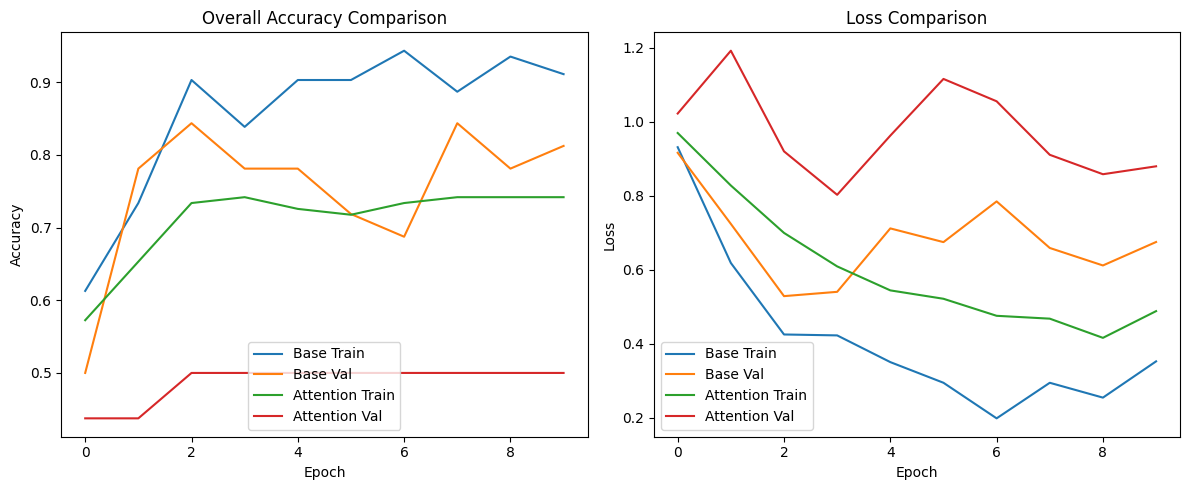


=== Final Results ===
Pure FixMatch:
Best Validation Accuracy: 84.38%

FixMatch + Medical Attention:
Best Validation Accuracy: 50.00%


In [ ]:
def run_ablation_study():
    set_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # 加载数据
    print("\nLoading RAD dataset...")
    train_path = '/content/drive/MyDrive/PhD/Research1/RADdataset/train-00000-of-00001-eb8844602202be60.parquet'
    test_path = '/content/drive/MyDrive/PhD/Research1/RADdataset/test-00000-of-00001-e5bc3d208bb4deeb.parquet'

    train_df = pd.read_parquet(train_path)
    test_df = pd.read_parquet(test_path)
    combined_df = pd.concat([train_df, test_df], ignore_index=True)

    # 创建数据集
    labeled_dataset = RADDataset(combined_df, is_labeled=True, mode='train')
    unlabeled_dataset = RADDataset(combined_df, is_labeled=False)
    test_dataset = RADDataset(combined_df, is_labeled=True, mode='test')

    # 划分训练集和验证集
    train_size = int(0.8 * len(labeled_dataset))
    val_size = len(labeled_dataset) - train_size
    train_dataset, val_dataset = random_split(labeled_dataset, [train_size, val_size])

    # 创建数据加载器
    batch_size = 8
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    unlabeled_loader = DataLoader(
        unlabeled_dataset,
        batch_size=batch_size*2,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    # 1. 运行纯FixMatch
    print("\n=== Running Pure FixMatch ===")
    base_model = BaseModalityClassifier().to(device)
    base_history = train_fixmatch(
        base_model, train_loader, unlabeled_loader, val_loader,
        device, "base_fixmatch"
    )

    # 2. 运行FixMatch+医学注意力
    print("\n=== Running FixMatch + Medical Attention ===")
    attention_model = AttentionModalityClassifier().to(device)
    attention_history = train_fixmatch(
        attention_model, train_loader, unlabeled_loader, val_loader,
        device, "attention_fixmatch"
    )

    # 绘制结果对比
    plot_training_history(base_history, attention_history)

    # 打印最终结果
    print("\n=== Final Results ===")
    print("Pure FixMatch:")
    print(f"Best Validation Accuracy: {100.*max(base_history['val_acc']):.2f}%")
    print("\nFixMatch + Medical Attention:")
    print(f"Best Validation Accuracy: {100.*max(attention_history['val_acc']):.2f}%")

if __name__ == "__main__":
    run_ablation_study()

In [ ]:
#测试slake用上面的半监督模型:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import pandas as pd
import numpy as np
from PIL import Image
import json
import os
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# 重新定义模型结构以便加载参数
class BaseModalityClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.backbone = models.resnet50(weights=None)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.modality_head = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.modality_head(features)

# 医学注意力模块
class MedicalModalityAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.anatomy_attention = nn.Sequential(
            nn.Conv2d(in_channels, in_channels//2, kernel_size=7, padding=3),
            nn.BatchNorm2d(in_channels//2),
            nn.ReLU(),
            nn.Conv2d(in_channels//2, 1, kernel_size=1),
            nn.Sigmoid()
        )

        self.texture_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels//16, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels//16, in_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        anatomy_weight = self.anatomy_attention(x)
        texture_weight = self.texture_attention(x)
        return x * anatomy_weight * texture_weight

# 注意力模型
class AttentionModalityClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.backbone = models.resnet50(weights=None)

        self.attention1 = MedicalModalityAttention(256)
        self.attention2 = MedicalModalityAttention(512)
        self.attention3 = MedicalModalityAttention(1024)
        self.attention4 = MedicalModalityAttention(2048)

        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.modality_head = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.attention1(self.backbone.layer1(x))
        x = self.attention2(self.backbone.layer2(x))
        x = self.attention3(self.backbone.layer3(x))
        x = self.attention4(self.backbone.layer4(x))

        x = self.backbone.avgpool(x)
        features = torch.flatten(x, 1)
        return self.modality_head(features)

class SLAKEDataset(Dataset):
    def __init__(self, json_path, base_dir):
        with open(json_path, 'r', encoding='utf-8') as f:
            self.data = json.load(f)

        # 仅保留英文问题
        self.samples = [item for item in self.data if item['q_lang'] == 'en']

        self.base_dir = base_dir
        self.modality_to_idx = {'MRI': 0, 'CT': 1, 'X-ray': 2, 'Xray': 2, 'X-Ray': 2, 'XRAY': 2}

        # 检查并统计模态分布
        modality_counts = {}
        for item in self.samples:
            modality = item.get('modality', 'Unknown')
            modality_counts[modality] = modality_counts.get(modality, 0) + 1

        print("模态分布统计:")
        for modality, count in modality_counts.items():
            print(f"  {modality}: {count}样本")

        # 标准化预处理
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        print(f"总共加载了 {len(self.samples)} 个英文测试样本")

        # 设置图像目录名
        self.img_dir_name = 'imgs'  # 基于你提供的信息

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # 加载图像
        img_path = os.path.join(self.base_dir, self.img_dir_name, sample['img_name'])

        try:
            image = Image.open(img_path).convert('RGB')
            image_tensor = self.transform(image)

            # 获取标签 - 使用每个样本的modality字段作为真实标签
            modality = sample.get('modality', None)

            # 标准化模态名称
            if modality:
                if modality.upper() in ['XRAY', 'X-RAY', 'X RAY']:
                    modality = 'X-ray'
                elif modality.upper() == 'MR':
                    modality = 'MRI'

            # 检查是否在已知模态中
            if modality in self.modality_to_idx:
                label = self.modality_to_idx[modality]
            else:
                # 未知模态或无模态信息
                label = -1

            return image_tensor, label, sample['img_id']

        except Exception as e:
            print(f"加载图像错误 {img_path}: {e}")
            # 返回一个空白图像和无效标签
            dummy_image = torch.zeros(3, 224, 224)
            return dummy_image, -1, sample['img_id']

使用设备: cuda
测试JSON文件路径: /content/drive/MyDrive/PhD/Research1/slakedataset/Slake1.0/test.json
检查文件是否存在: True
模态分布统计:
  CT: 472样本
  X-Ray: 361样本
  MRI: 228样本
总共加载了 1061 个英文测试样本

加载基础模型: /content/drive/MyDrive/PhD/Research1/output/base_fixmatch_best.pth


Testing 基础模型(Base): 100%|██████████| 67/67 [00:58<00:00,  1.14it/s]



基础模型(Base) 测试结果:
总体准确率: 97.55%
各模态准确率:
MRI: 100.00% (228/228)
CT: 94.49% (446/472)
X-ray: 100.00% (361/361)


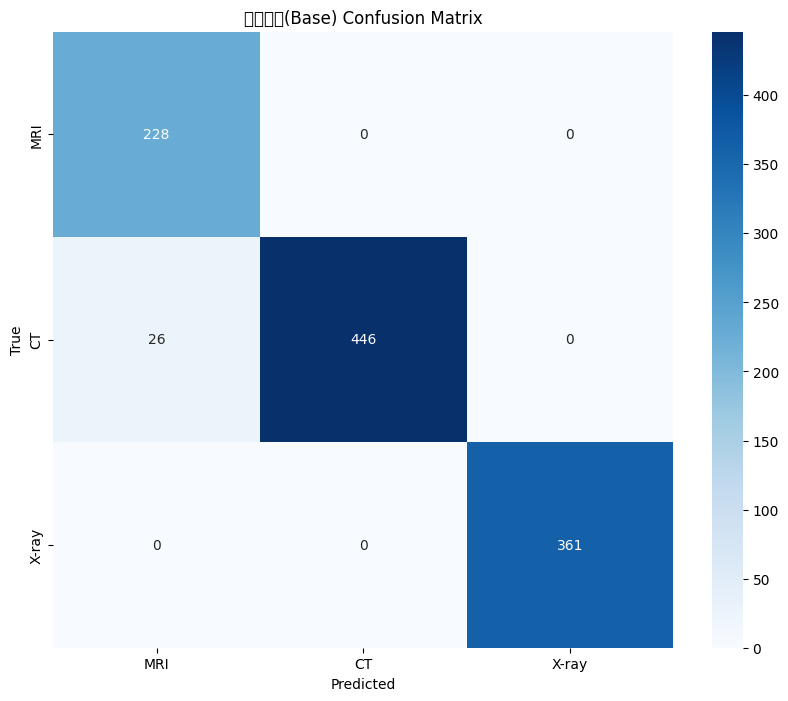


分类报告:
              precision    recall  f1-score   support

         MRI     0.8976    1.0000    0.9461       228
          CT     1.0000    0.9449    0.9717       472
       X-ray     1.0000    1.0000    1.0000       361

    accuracy                         0.9755      1061
   macro avg     0.9659    0.9816    0.9726      1061
weighted avg     0.9780    0.9755    0.9758      1061


错误预测样本数: 26
错误预测样本示例:
   img_id true_modality pred_modality
0     219            CT           MRI
1     219            CT           MRI
2     219            CT           MRI
3     219            CT           MRI
4     219            CT           MRI
5     219            CT           MRI
6     219            CT           MRI
7     219            CT           MRI
8     219            CT           MRI
9     219            CT           MRI

加载注意力模型: /content/drive/MyDrive/PhD/Research1/output/attention_fixmatch_best.pth


Testing 注意力模型(Attention): 100%|██████████| 67/67 [00:05<00:00, 12.13it/s]



注意力模型(Attention) 测试结果:
总体准确率: 54.67%
各模态准确率:
MRI: 96.05% (219/228)
CT: 0.00% (0/472)
X-ray: 100.00% (361/361)


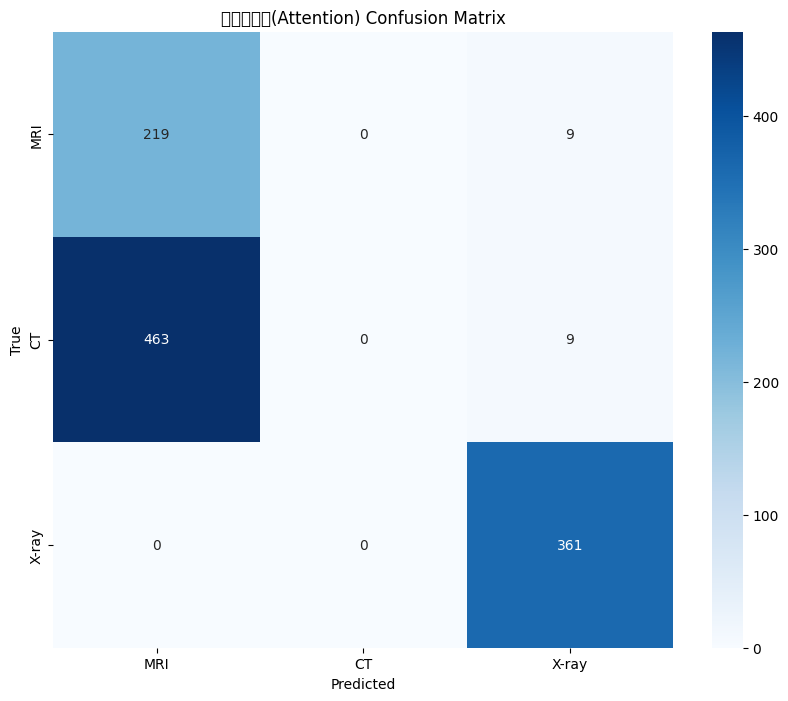


分类报告:
              precision    recall  f1-score   support

         MRI     0.3211    0.9605    0.4813       228
          CT     0.0000    0.0000    0.0000       472
       X-ray     0.9525    1.0000    0.9757       361

    accuracy                         0.5467      1061
   macro avg     0.4245    0.6535    0.4857      1061
weighted avg     0.3931    0.5467    0.4354      1061


错误预测样本数: 481
错误预测样本示例:
   img_id true_modality pred_modality
0     102            CT           MRI
1     102            CT           MRI
2     102            CT           MRI
3     102            CT           MRI
4     102            CT           MRI
5     102            CT           MRI
6     102            CT           MRI
7     102            CT           MRI
8     102            CT           MRI
9     102            CT           MRI

=== 模型对比总结 ===

基础模型:
总体准确率: 97.55%
各模态准确率:
  MRI: 100.00%
  CT: 94.49%
  X-ray: 100.00%

注意力模型:
总体准确率: 54.67%
各模态准确率:
  MRI: 96.05%
  CT: 0.00%
  X-ray: 100.00%


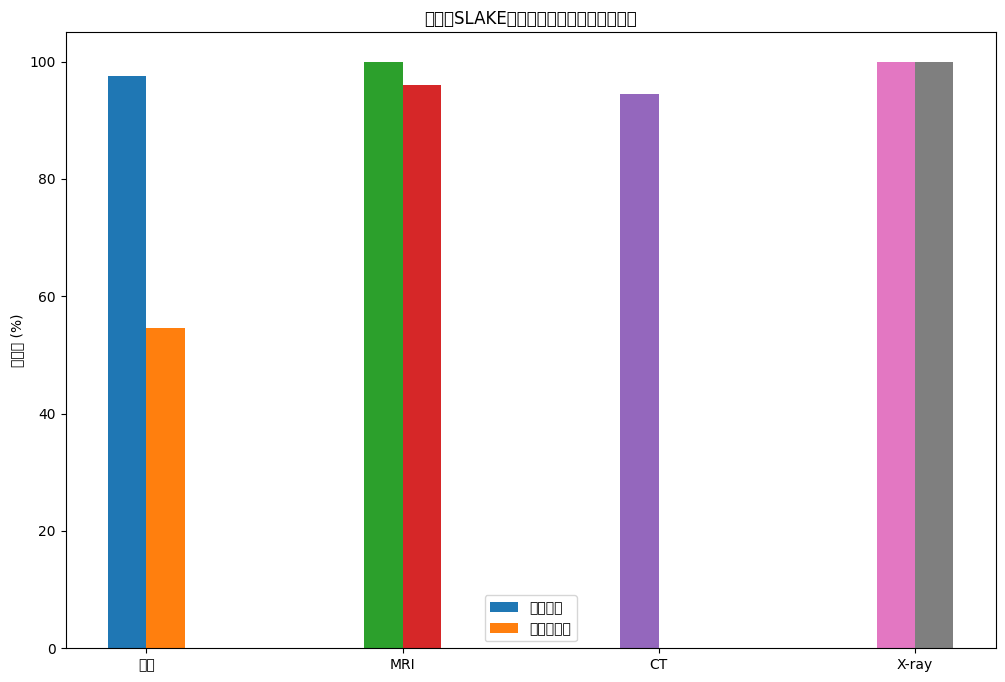

In [ ]:
def test_model(model, test_loader, device, model_name):
    model.eval()
    all_preds = []
    all_labels = []
    all_img_ids = []
    correct = 0
    total = 0

    # 用于记录每个模态的准确度
    modality_correct = {'MRI': 0, 'CT': 0, 'X-ray': 0}
    modality_total = {'MRI': 0, 'CT': 0, 'X-ray': 0}
    idx_to_modality = {0: 'MRI', 1: 'CT', 2: 'X-ray'}

    with torch.no_grad():
        for inputs, labels, img_ids in tqdm(test_loader, desc=f'Testing {model_name}'):
            # 将img_ids保持在CPU上
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 在CPU上创建掩码
            valid_mask = (labels >= 0).cpu()

            # 筛选有效标签的样本
            if not valid_mask.any():
                continue

            # 在移动到设备前应用掩码
            valid_inputs = inputs[valid_mask].to(device)
            valid_labels = labels[valid_mask].to(device)
            valid_img_ids = img_ids[valid_mask]  # img_ids保持在CPU上


            if len(valid_inputs) == 0:
                continue

            outputs = model(valid_inputs)
            _, predicted = outputs.max(1)

            # 记录预测结果
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(valid_labels.cpu().numpy())
            all_img_ids.extend(valid_img_ids.cpu().numpy())

            # 计算总体准确率
            total += valid_labels.size(0)
            correct += predicted.eq(valid_labels).sum().item()

            # 计算每个模态的准确率
            for i, (pred, label) in enumerate(zip(predicted, valid_labels)):
                modality = idx_to_modality[label.item()]
                modality_total[modality] += 1
                if pred == label:
                    modality_correct[modality] += 1

    # 计算总体准确率
    overall_acc = correct / total if total > 0 else 0
    print(f'\n{model_name} 测试结果:')
    print(f'总体准确率: {100.*overall_acc:.2f}%')

    # 计算并打印每个模态的准确率
    print('各模态准确率:')
    for modality in modality_total.keys():
        if modality_total[modality] > 0:
            acc = modality_correct[modality] / modality_total[modality]
            print(f'{modality}: {100.*acc:.2f}% ({modality_correct[modality]}/{modality_total[modality]})')

    # 生成混淆矩阵
    if len(all_labels) > 0:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                  xticklabels=['MRI', 'CT', 'X-ray'],
                  yticklabels=['MRI', 'CT', 'X-ray'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'{model_name} Confusion Matrix')
        plt.savefig(f'/content/drive/MyDrive/PhD/Research1/output/{model_name}_confusion_matrix.png')
        plt.show()

        # 生成详细的分类报告
        report = classification_report(all_labels, all_preds,
                                      target_names=['MRI', 'CT', 'X-ray'],
                                      digits=4)
        print("\n分类报告:")
        print(report)

        # 保存错误预测的图像ID
        error_indices = [i for i in range(len(all_preds)) if all_preds[i] != all_labels[i]]
        error_img_ids = [all_img_ids[i] for i in error_indices]
        error_true = [idx_to_modality[all_labels[i]] for i in error_indices]
        error_pred = [idx_to_modality[all_preds[i]] for i in error_indices]

        error_df = pd.DataFrame({
            'img_id': error_img_ids,
            'true_modality': error_true,
            'pred_modality': error_pred
        })

        print(f"\n错误预测样本数: {len(error_indices)}")
        if len(error_indices) > 0:
            print("错误预测样本示例:")
            print(error_df.head(10))
            error_df.to_csv(f'/content/drive/MyDrive/PhD/Research1/output/{model_name}_errors.csv', index=False)

    return overall_acc, {modality: modality_correct[modality]/modality_total[modality]
                        if modality_total[modality] > 0 else 0
                        for modality in modality_total.keys()}

def main():
    # 设置设备
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用设备: {device}")

    # 定义数据路径
    slake_base_dir = '/content/drive/MyDrive/PhD/Research1/slakedataset/Slake1.0'
    json_path = os.path.join(slake_base_dir, 'test.json')

    # 打印测试文件路径以确认
    print(f"测试JSON文件路径: {json_path}")
    print(f"检查文件是否存在: {os.path.exists(json_path)}")

    # 模型保存路径
    base_model_path = '/content/drive/MyDrive/PhD/Research1/output/base_fixmatch_best.pth'
    attention_model_path = '/content/drive/MyDrive/PhD/Research1/output/attention_fixmatch_best.pth'

    # 创建数据集和数据加载器
    test_dataset = SLAKEDataset(json_path, slake_base_dir)
    test_loader = DataLoader(
        test_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # 验证数据集是否加载成功
    if len(test_dataset) == 0:
        print("警告: 测试数据集为空，请检查数据路径和过滤条件")
        return

    results = {}

    # 测试基础模型
    if os.path.exists(base_model_path):
        print(f"\n加载基础模型: {base_model_path}")
        base_model = BaseModalityClassifier().to(device)
        checkpoint = torch.load(base_model_path, map_location=device)
        base_model.load_state_dict(checkpoint['model_state_dict'])
        base_acc, base_modality_acc = test_model(base_model, test_loader, device, "基础模型(Base)")
        results['基础模型'] = {'总体准确率': base_acc, '模态准确率': base_modality_acc}
    else:
        print(f"找不到基础模型: {base_model_path}")

    # 测试注意力模型
    if os.path.exists(attention_model_path):
        print(f"\n加载注意力模型: {attention_model_path}")
        attention_model = AttentionModalityClassifier().to(device)
        checkpoint = torch.load(attention_model_path, map_location=device)
        attention_model.load_state_dict(checkpoint['model_state_dict'])
        attention_acc, attention_modality_acc = test_model(attention_model, test_loader, device, "注意力模型(Attention)")
        results['注意力模型'] = {'总体准确率': attention_acc, '模态准确率': attention_modality_acc}
    else:
        print(f"找不到注意力模型: {attention_model_path}")

    # 总结结果
    if results:
        print("\n=== 模型对比总结 ===")
        for model_name, metrics in results.items():
            print(f"\n{model_name}:")
            print(f"总体准确率: {100.*metrics['总体准确率']:.2f}%")
            print("各模态准确率:")
            for modality, acc in metrics['模态准确率'].items():
                print(f"  {modality}: {100.*acc:.2f}%")

        # 可视化对比
        if len(results) > 1:
            modalities = list(next(iter(results.values()))['模态准确率'].keys())
            model_names = list(results.keys())

            # 准备数据
            overall_accs = [results[model]['总体准确率'] * 100 for model in model_names]
            modality_accs = {modality: [results[model]['模态准确率'][modality] * 100
                                      for model in model_names]
                           for modality in modalities}

            # 绘制对比图
            fig, ax = plt.subplots(figsize=(12, 8))
            bar_width = 0.15
            index = np.arange(len(modalities) + 1)  # +1 for overall

            # 添加总体准确率
            for i, model_name in enumerate(model_names):
                offset = (i - len(model_names)/2 + 0.5) * bar_width
                ax.bar(index[0] + offset, overall_accs[i], bar_width,
                     label=model_name)

            # 添加各模态准确率
            for i, modality in enumerate(modalities):
                for j, model_name in enumerate(model_names):
                    offset = (j - len(model_names)/2 + 0.5) * bar_width
                    ax.bar(index[i+1] + offset, modality_accs[modality][j],
                         bar_width)

            ax.set_ylabel('准确率 (%)')
            ax.set_title('模型在SLAKE数据集上的模态分类性能对比')
            ax.set_xticks(index)
            ax.set_xticklabels(['总体'] + list(modalities))
            ax.legend()

            plt.savefig('/content/drive/MyDrive/PhD/Research1/output/slake_comparison.png')
            plt.show()

if __name__ == "__main__":
    main()

In [ ]:
#----mri增强

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from PIL import Image
import io
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import re
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


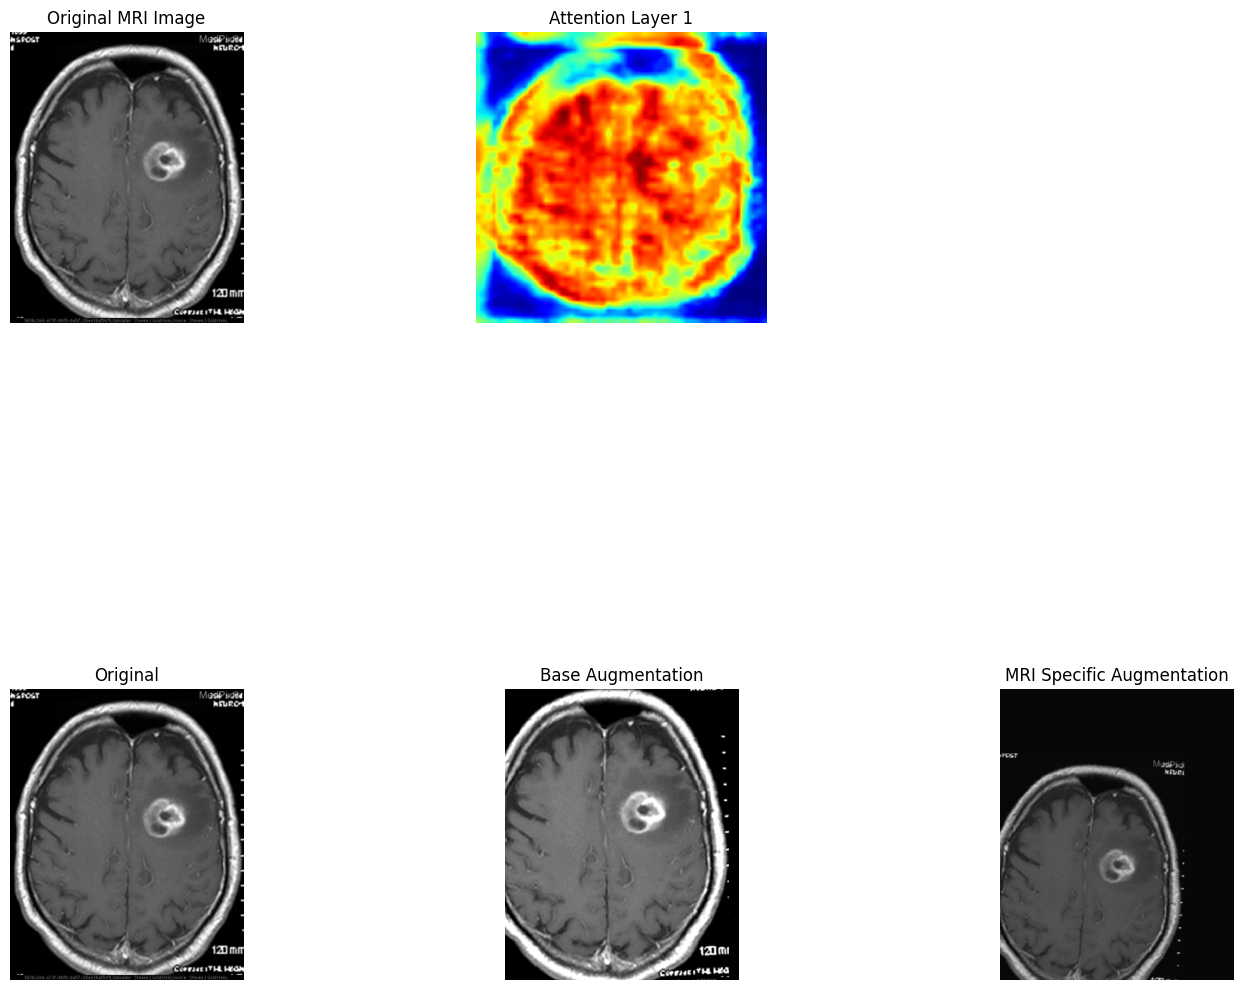


Question: how was this image taken?

Answer: mri


In [ ]:
def find_mri_sample(df):
    """找到一个明确标注为MRI的样本"""
    for idx, row in df.iterrows():
        if isinstance(row['answer'], str) and 'mri' in row['answer'].lower():
            return row
    return None

def decode_image(image_data):
    """解码图像数据"""
    try:
        if isinstance(image_data, dict):
            if 'bytes' in image_data:
                bytes_data = image_data['bytes']
                if isinstance(bytes_data, str):
                    bytes_data = bytes_data.encode('latin1')
                img = Image.open(io.BytesIO(bytes_data))
                return np.array(img)
            elif 'array' in image_data:
                return np.array(image_data['array'])
        return np.array(image_data)
    except Exception as e:
        print(f"Error decoding image: {str(e)}")
        raise

def process_attention_maps(image, attention_model):
    """生成注意力图"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    attention_model = attention_model.to(device)
    attention_model.eval()

    # 转换图像为tensor
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    image_tensor = transform(Image.fromarray(image)).unsqueeze(0).to(device)

    # 获取各层注意力图
    attention_maps = []
    with torch.no_grad():
        x = attention_model.backbone.conv1(image_tensor)
        x = attention_model.backbone.bn1(x)
        x = attention_model.backbone.relu(x)
        x = attention_model.backbone.maxpool(x)

        # 获取每层的注意力图
        attentions = [
            attention_model.attention1,
            attention_model.attention2,
            attention_model.attention3,
            attention_model.attention4
        ]

        for i, (layer, attention) in enumerate([
            (attention_model.backbone.layer1, attentions[0]),
            (attention_model.backbone.layer2, attentions[1]),
            (attention_model.backbone.layer3, attentions[2]),
            (attention_model.backbone.layer4, attentions[3])
        ]):
            x = layer(x)
            # 获取解剖结构注意力和纹理注意力
            anatomy_attention = attention.anatomy_attention(x)
            texture_attention = attention.texture_attention(x)

            # 上采样到原始大小
            attention_map = (anatomy_attention * texture_attention).mean(1, keepdim=True) # Keep the channel dimension
            attention_map = nn.functional.interpolate(
                attention_map, size=(224, 224), mode='bilinear', align_corners=False
            )
            attention_maps.append(attention_map.squeeze().cpu().numpy())

            return attention_maps

def apply_mri_augmentations(image):
    """应用MRI特殊增强"""
    # 基础增强
    base_aug = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.RandomAffine(
            degrees=0,
            translate=(0.1, 0.1),
            scale=(0.9, 1.1)
        ),
        transforms.ColorJitter(brightness=0.2, contrast=0.2)
    ])

    # MRI特殊增强
    mri_aug = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.RandomAffine(
            degrees=0,
            translate=(0.15, 0.15),
            scale=(0.85, 1.15)
        ),
        transforms.ColorJitter(
            brightness=0.3,
            contrast=0.3,
            saturation=0.2,
            hue=0.1
        )
    ])

    # 应用增强
    pil_image = Image.fromarray(image)
    base_augmented = base_aug(pil_image)
    mri_augmented = mri_aug(pil_image)

    return np.array(base_augmented), np.array(mri_augmented)

def visualize_mri_processing(df, attention_model):
    """可视化MRI处理步骤"""
    # 找到MRI样本
    mri_sample = find_mri_sample(df)
    if mri_sample is None:
        print("No MRI sample found!")
        return

    # 解码并处理图像
    original_image = decode_image(mri_sample['image'])
    if len(original_image.shape) == 2:
        original_image = np.stack([original_image] * 3, axis=-1)

    # 获取注意力图
    attention_maps = process_attention_maps(original_image, attention_model)

    # 应用数据增强
    base_augmented, mri_augmented = apply_mri_augmentations(original_image)

    # 创建可视化
    plt.figure(figsize=(15, 10))

    # 原图
    plt.subplot(3, 3, 1)
    plt.imshow(original_image)
    plt.title('Original MRI Image')
    plt.axis('off')

    # 注意力图
    for i, attention_map in enumerate(attention_maps):
        plt.subplot(3, 3, i + 2)
        plt.imshow(attention_map, cmap='jet')
        plt.title(f'Attention Layer {i+1}')
        plt.axis('off')

    # 数据增强对比
    plt.subplot(3, 3, 7)
    plt.imshow(original_image)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(3, 3, 8)
    plt.imshow(base_augmented)
    plt.title('Base Augmentation')
    plt.axis('off')

    plt.subplot(3, 3, 9)
    plt.imshow(mri_augmented)
    plt.title('MRI Specific Augmentation')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 打印相关的问题和回答
    print("\nQuestion:", mri_sample['question'])
    print("\nAnswer:", mri_sample['answer'])

def main():
    # 加载数据集
    train_path = '/content/drive/MyDrive/PhD/Research1/RADdataset/train-00000-of-00001-eb8844602202be60.parquet'
    df = pd.read_parquet(train_path)

    # 创建注意力模型
    attention_model = AttentionModalityClassifier()

    # 如果有预训练模型，加载权重
    model_path = 'attention_fixmatch_best.pth'
    if os.path.exists(model_path):
        checkpoint = torch.load(model_path)
        attention_model.load_state_dict(checkpoint['model_state_dict'])

    # 可视化处理步骤
    visualize_mri_processing(df, attention_model)

if __name__ == "__main__":
    main()

In [ ]:
#----